# Economic Dispatch

Economic dispatch is the process of deciding the most optimal economic dispatch strategy from a given generator portfolio to reliably meet power demand (load).

**1. Load packages and useful definitions**
   - We are using the gurobipy package to formulate a mathematical model and solve it. 

In [1]:
# import required packages

import pandas as pd
import numpy as np

import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt

In [2]:
# some helpful definitions

gen_colors = {
    "Hydro": "#1f78b4",  # Deep Blue
    "Nuclear": "#e31a1c",  # Red
    "Coal": "#8b4513",  # Dark Brown
    "Gas CC": "#8e44ad",  # Medium Purple
    "Gas CT": "#a569bd",  # Light Purple
    "Oil CT": "#4d4d4d",  # Dark Gray
    "Wind": "#6baed6",  # Light Sky Blue
    "PV": "#ff7f00"  # Bright Orange
}

def print_gp_status(m):
    status = m.Status
    if status == GRB.OPTIMAL:
        print("The model is optimal.")
    elif status == GRB.INFEASIBLE:
        print("The model is infeasible.")
    elif status == GRB.UNBOUNDED:
        print("The model is unbounded.")
    else:
        print(f"Optimization ended with status {status}.")
    print()
    return status

**2. Read and prepare data**
- The data is simplified generator data. We have entries for each type of generator (not generator unit specific).
- It includes cost data, fixed cost and variable cost. It also includes technical limitations like the installed amount, minimum generation levels, ramping rates, minimum down time and minimum up time (minimum run time). 

In [3]:
# read the data
data_file = "ts_and_gen.xlsx"
load_and_res_data = pd.read_excel(data_file, sheet_name=0)
gen_data = pd.read_excel(data_file, sheet_name=1)

In [4]:
# inspect the data
gen_data

,Unit Type,Fixed Cost USD/kW,Variable Cost USD/MWh,Installed in MW,PMin in MW,Ramp Rate in MW /hr,Min Down Time Hr,Min Up Time Hr
0,Nuclear,8000,3,3000,2650,300,48,24
1,Oil CT,1200,50,2000,400,1500,1,1
2,Coal,3000,10,5000,1750,2000,10,10
3,Hydro,3000,2,3000,0,3000,0,0
4,Gas CC,1000,25,15000,7500,2500,4,8
5,Gas CT,800,35,3000,600,9000,2,2


In [5]:
# prepare data for economic dispatch

# generator data
gen_type = gen_data['Unit Type'].to_numpy()
mc = gen_data['Variable Cost USD/MWh'].to_numpy()
Pmax = gen_data['Installed in MW'].to_numpy()
R60 = gen_data['Ramp Rate in MW /hr'].to_numpy()
n_gen = len(gen_type)

# load data
load = load_and_res_data['CAISO (MW)'].to_numpy()
n_t = len(load)

# Res data
wind = load_and_res_data['10 000 MW Onshore Wind'].to_numpy()
pv = load_and_res_data['15 000 MW Solar PV'].to_numpy()
curt_pen = 0 # $/MWh


**3. Inspect data**
- We can see the very typical duck curve (area between load and net-load looks like a duck). The net load is the load subtracted by RES production (in this case Wind and PV).

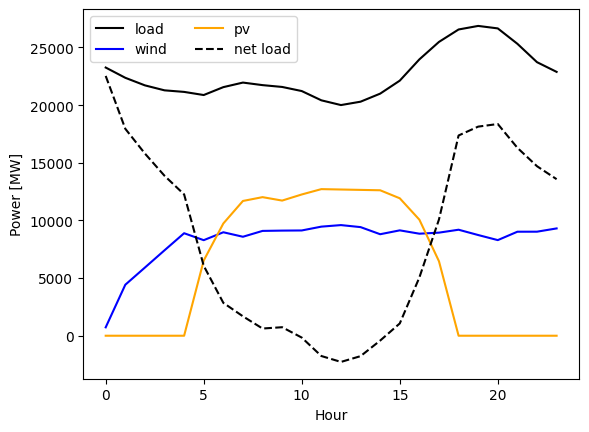

In [6]:
fig, ax = plt.subplots(1,1)
ax.plot(load, label="load", color="black")
ax.plot(wind, label="wind", color="blue")
ax.plot(pv, label="pv", color="orange")
ax.plot(load-wind-pv, label="net load", color="black", ls="--")
ax.set_ylabel("Power [MW]")
ax.set_xlabel("Hour")
ax.legend(ncols=2);

**4. Define mathematical model**
We implement the following economic dispatch with renewable energy generation (RES).

Objective function:
- Minimize the sum of cost of generation _$C_t^{\text{gen}}$_ and curtailment _$C_t^{\text{curt}}$_ over time _T_.
  
Decision variables:
- _$p_{i,t}^{\text{c}}$_ production of conventional generator _i_ in _t_.
- _$p_{i,t}^{\text{w}}$_ production of wind generator _i_ in _t_.
- _$p_{i,t}^{\text{pv}}$_ production of PV _i_ in _t_.

Constraints:
- Generation cost _$C_t^{\text{gen}}$_ is equal to the cost function _$c_i(p^{\text{c}}_{i,t})$_ 
- Curtailment cost _$C_t^{\text{curt}}$_ is equal to the difference between the RES production limit _$\overline{P}_{i,t}^{\text{w}}$_, _$\overline{P}_{i,t}^{\text{pv}}$_ and the realized production of RES _$p_{i,t}^{\text{w}}$_, _$p_{i,t}^{\text{pv}}$_.
- The sum of generation needs to equal the demand _$D_t$_ in each _t_.
- Generator output needs to be greater or equal to _0_ and smaller or equal to their respective production limits, which are time-dependent _t_ for RES.
- Conventional generators have ramping constraints, which limits how much their generation _$p_{i,t}^{\text{c}}$_ can change up or down from one time step to the next. It is limit by _$R_i^{\text{60}}$_.


\begin{align}
\min \quad 
    & \sum_{t=1}^T C_t^{\text{gen}} + C_t^{\text{curt}} \\
\text{s.t.} \quad 
    & C_t^{\text{gen}} = \sum_{i \in [G]} c_i(p^{\text{c}}_{i,t}) && \forall t \in [T] \\
    & C_t^{\text{curt}} = c^{\text{curt}} \Big[ \sum_{i \in W} (\overline{P}_{i,t}^{\text{w}} -  p_{i,t}^{\text{w}}) + \sum_{i \in [PV]} (\overline{P}_{i,t}^{\text{pv}} -  p_{i,t}^{\text{pv}}) \Big] && \forall t \in [T]  \\
    & \sum_{i \in [G]} p_{i,t}^{\text{c}} + \sum_{i \in [W]} p_{i,t}^{\text{w}} + \sum_{i \in [PV]} p_{i,t}^{\text{pv}} = D_t && \forall t \in [T]  \\
    & 0 \leq p_{i,t}^{\text{c}} \leq \overline{P}_{i} && \forall i \in [G]  \\
    & 0 \leq p_{i,t}^{\diamond} \leq \overline{P}_{i,t}, \quad  \diamond=\{\text{w, pv}\} && \forall i \in [G] , t \in [T]  \\
    & |p_{i,t}^{\text{c}} - p_{i,t-1}^{\text{c}} | \leq R_i^{\text{60}} && \forall i \in [G], t \in [T] 
\end{align}



In [7]:
# write the ED model
m = gp.Model()
m.setParam("OutputFlag", 0)

# add variables
p = m.addVars(n_gen, n_t, lb=0, ub=GRB.INFINITY, name="p")
p_wind = m.addVars(n_t, lb=0, ub=GRB.INFINITY, name="p_wind")
p_pv = m.addVars(n_t, lb=0, ub=GRB.INFINITY, name="p_pv")

# energy balance
m.addConstrs((sum(p[i,t] for i in range(n_gen)) + p_wind[t] + p_pv[t] == load[t] for t in range(n_t)), name="energy_balance")

# generator constraints
for t in range(n_t):
    for i in range(n_gen):
        # maximum generation
        m.addConstr(p[i,t] <= Pmax[i])
        # ramping
        if t>0:
            m.addConstr(p[i,t] - p[i,t-1] <= R60[i])
            m.addConstr(p[i,t-1] - p[i,t] <= R60[i])

# RES constraints
for t in range(n_t):
    m.addConstr(p_wind[t] <= wind[t])
    m.addConstr(p_pv[t] <= pv[t])
        
# objective
gen_cost = sum(sum(mc[i]*p[i,t] for i in range(n_gen)) for t in range(n_t))
curt_cost = sum(curt_pen* ((pv[t]-p_pv[t]) + (wind[t]-p_wind[t])) for t in range(n_t))
m.setObjective(
    gen_cost + curt_cost, GRB.MINIMIZE
)

# run
m.optimize()

Set parameter Username


Academic license - for non-commercial use only - expires 2025-11-15


**5. Inspect the solution and plot the dispatch**

The model is optimal.

Objective value 2.460 M$.

A total of 10980.62 MWh wind were curtailed.
A total of 5392.55 MWh PV were curtailed.


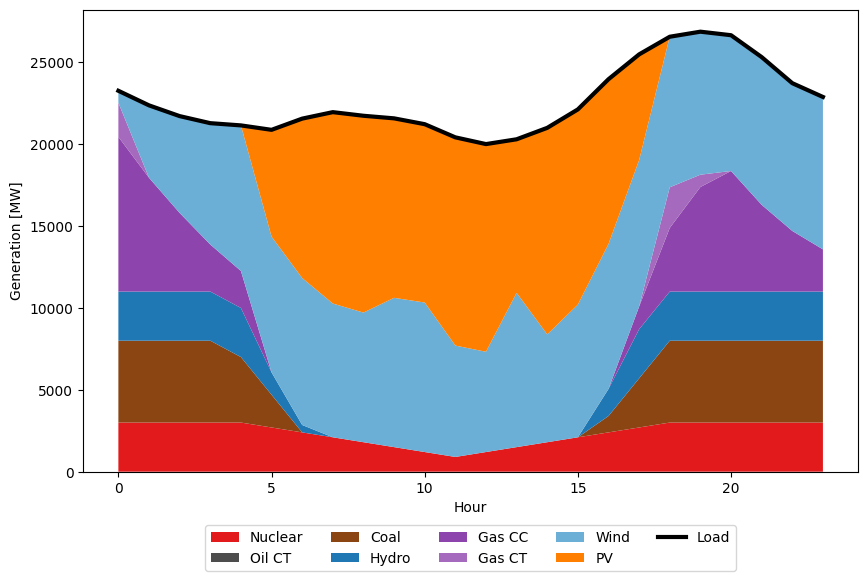

In [8]:
# Check the status of the solver
print_gp_status(m)

# Objective value
objective = m.ObjVal
print(f"Objective value {objective/1e6:.3f} M$.\n")

# prodcution plot
p_res = {type: [m.getVarByName(f"p[{i},{t}]").X for t in range(n_t)] for (i,type) in enumerate(gen_type)}
p_res['Wind'] = [m.getVarByName(f"p_wind[{t}]").X for t in range(n_t)]
p_res['PV'] = [m.getVarByName(f"p_pv[{t}]").X for t in range(n_t)]

#curtailment
wind_curt_res = wind - np.array(p_res['Wind'])
pv_curt_res = pv - np.array(p_res['PV'])
print(f"A total of {sum(wind_curt_res):.2f} MWh wind were curtailed.")
print(f"A total of {sum(pv_curt_res):.2f} MWh PV were curtailed.")

# plot
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,6)
x = np.arange(24)
color_list = [gen_colors[g] for g in list(p_res.keys())]
ax.stackplot(x, list(p_res.values()), labels=list(p_res.keys()), colors=color_list);
ax.plot(load, linewidth=3, color='black', label='Load')
ax.set_xlabel("Hour")
ax.set_ylabel("Generation [MW]")
ax.legend(ncols=5, loc="lower center", bbox_to_anchor=(0.5, -0.23));